In [1]:
import os
import argparse
from typing import List, Dict, Tuple
import pandas as pd
import numpy as np
from dataclasses import dataclass

In [2]:
# LlamaIndex / retrieval
from llama_index.core.schema import NodeWithScore, TextNode
from llama_index.core import VectorStoreIndex, StorageContext
# Qdrant + BM25
from rank_bm25 import BM25Okapi

In [1]:
import sys
sys.path.insert(0, "../")
from search_process import prepare_search,as_results,dedup_exact_question,CorpusItem,build_reranker

In [8]:
K = 5  # we’ll evaluate @5 as requested
# knobs
VEC_TOP_K = max(12, K)      # gather more for better recall
BM25_TOP_K = max(12, K)
RERANK_TOP_N = max(8, K)
FINAL_TOP_N = K  

# -----------------------------
# Retrieval modes
# -----------------------------

In [9]:
def retrieve_vector_only(index: VectorStoreIndex, query: str) -> List[Dict]:
    retriever = index.as_retriever(similarity_top_k=VEC_TOP_K)
    nodes = retriever.retrieve(query)
    # no rerank, no bm25
    rows = as_results(nodes)
    return dedup_exact_question(rows)

In [12]:
def retrieve_hybrid(index: VectorStoreIndex, bm25: BM25Okapi, corpus: Dict[str, CorpusItem], query: str) -> List[Dict]:
    # vector
    v_nodes = index.as_retriever(similarity_top_k=VEC_TOP_K).retrieve(query)
    # bm25
    scores = bm25.get_scores(query.lower().split())
    # map indices to doc_ids (BM25 insertion order matches corpus order)
    doc_ids = list(corpus.keys())
    ranked = sorted(enumerate(scores), key=lambda x: x[1], reverse=True)[:BM25_TOP_K]
    b_nodes: List[NodeWithScore] = []
    for idx, sc in ranked:
        did = doc_ids[idx]
        item = corpus[did]
        b_nodes.append(NodeWithScore(node=TextNode(id_=did, text=item.text, metadata=item.metadata), score=float(sc)))

    # simple union by doc_id, keep higher score
    merged: Dict[str, NodeWithScore] = {}
    for n in v_nodes + b_nodes:
        did = n.metadata.get("doc_id") if n.metadata else n.node.node_id
        if did not in merged or (merged[did].score or 0) < (n.score or 0):
            merged[did] = n

    rows = as_results(list(merged.values()))
    return dedup_exact_question(rows)

In [13]:

def retrieve_hybrid_rerank(index: VectorStoreIndex, bm25: BM25Okapi, corpus: Dict[str, CorpusItem], query: str) -> List[Dict]:
    # stage 1: gather candidates (same as hybrid)
    v_nodes = index.as_retriever(similarity_top_k=VEC_TOP_K).retrieve(query)

    scores = bm25.get_scores(query.lower().split())
    doc_ids = list(corpus.keys())
    ranked = sorted(enumerate(scores), key=lambda x: x[1], reverse=True)[:BM25_TOP_K]
    b_nodes: List[NodeWithScore] = []
    for idx, sc in ranked:
        did = doc_ids[idx]
        item = corpus[did]
        b_nodes.append(NodeWithScore(node=TextNode(id_=did, text=item.text, metadata=item.metadata), score=float(sc)))

    # merge by doc_id
    merged: Dict[str, NodeWithScore] = {}
    for n in v_nodes + b_nodes:
        did = n.metadata.get("doc_id") if n.metadata else n.node.node_id
        if did not in merged or (merged[did].score or 0) < (n.score or 0):
            merged[did] = n

    # stage 2: rerank with cross-encoder
    reranker = build_reranker()
    reranked = reranker.postprocess_nodes(list(merged.values()), query_str=query)

    rows = as_results(reranked)
    return dedup_exact_question(rows)

# -----------------------------
# Metrics
# -----------------------------

In [14]:
def normalized(s: str) -> str:
    return (s or "").strip().lower()


def hit_rate_at_k(expected: str, results: List[Dict]) -> int:
    """1 if any result's answer contains or equals expected (lenient), else 0."""
    e = normalized(expected)
    for r in results:
        a = normalized(r.get("answer"))
        # lenient containment match helps small wording differences
        if e and (e == a or e in a or a in e):
            return 1
    return 0

In [15]:
def mrr_at_k(expected: str, results: List[Dict]) -> float:
    e = normalized(expected)
    for i, r in enumerate(results, 1):
        a = normalized(r.get("answer"))
        if e and (e == a or e in a or a in e):
            return 1.0 / i
    return 0.0

In [16]:
def evaluate(csv_path: str, index: VectorStoreIndex, bm25: BM25Okapi, corpus: Dict[str, CorpusItem]) -> pd.DataFrame:
    df = pd.read_csv(csv_path)
    rows = []

    for _, row in df.iterrows():
        q = str(row["question"])
        gt = str(row["expected_answer"])

        # Mode 1: vector
        res_vec = retrieve_vector_only(index, q)
        hr_vec = hit_rate_at_k(gt, res_vec)
        mrr_vec = mrr_at_k(gt, res_vec)

        # Mode 2: hybrid
        res_hyb = retrieve_hybrid(index, bm25, corpus, q)
        hr_hyb = hit_rate_at_k(gt, res_hyb)
        mrr_hyb = mrr_at_k(gt, res_hyb)

        # Mode 3: hybrid + rerank
        res_rr = retrieve_hybrid_rerank(index, bm25, corpus, q)
        hr_rr = hit_rate_at_k(gt, res_rr)
        mrr_rr = mrr_at_k(gt, res_rr)

        rows.append({
            "query": q,
            "hit_vec@5": hr_vec, "mrr_vec@5": mrr_vec,
            "hit_hybrid@5": hr_hyb, "mrr_hybrid@5": mrr_hyb,
            "hit_hybrid_rerank@5": hr_rr, "mrr_hybrid_rerank@5": mrr_rr,
        })

    out = pd.DataFrame(rows)
    # summary
    summary = pd.DataFrame({
        "mode": ["vector", "hybrid", "hybrid+rerank"],
        "hit_rate@5": [
            out["hit_vec@5"].mean(),
            out["hit_hybrid@5"].mean(),
            out["hit_hybrid_rerank@5"].mean(),
        ],
        "mrr@5": [
            out["mrr_vec@5"].mean(),
            out["mrr_hybrid@5"].mean(),
            out["mrr_hybrid_rerank@5"].mean(),
        ],
    })
    return out, summary

In [17]:
prepare_dict = prepare_search()

In [18]:
index = prepare_dict['index']
bm25 = prepare_dict['bm25']
corpus = prepare_dict['corpus_items']

In [ ]:
per_query, summary = evaluate("../data/ground-truth-data.csv", index, bm25, corpus)

In [23]:
summary 

,mode,hit_rate@5,mrr@5
0,vector,0.923596,0.823221
1,hybrid,0.937079,0.827041
2,hybrid+rerank,0.957303,0.838989


In [24]:
import matplotlib.pyplot as plt
import numpy as np

In [25]:
def plot_metrics(summary_df):
    """
    Plot Hit Rate and MRR for all retrieval modes side by side.
    summary_df should be a pandas DataFrame like:
    
           mode  hit_rate@5   mrr@5
    0     vector     0.73     0.52
    1     hybrid     0.83     0.56
    2 hybrid+rerank  0.85     0.63
    """

    modes = summary_df["mode"].tolist()
    hit_rates = summary_df["hit_rate@5"].tolist()
    mrr_scores = summary_df["mrr@5"].tolist()

    x = np.arange(len(modes))
    width = 0.35

    plt.figure(figsize=(9, 5))
    bars1 = plt.bar(x - width / 2, hit_rates, width, label="Hit Rate@5", color="#007ACC")
    bars2 = plt.bar(x + width / 2, mrr_scores, width, label="MRR@5", color="#FFB000")

    # Add value labels above bars
    for bars in [bars1, bars2]:
        for bar in bars:
            yval = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                yval + 0.01,
                f"{yval:.2f}",
                ha="center",
                va="bottom",
                fontsize=9,
                fontweight="bold"
            )

    plt.ylabel("Score")
    plt.title("📊 Retrieval Performance Comparison (k=5)")
    plt.xticks(x, modes, fontsize=11)
    plt.ylim(0, 1.05)
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

C:\Users\zaina\AppData\Local\Temp\ipykernel_41172\1623574934.py:43: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\zaina\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


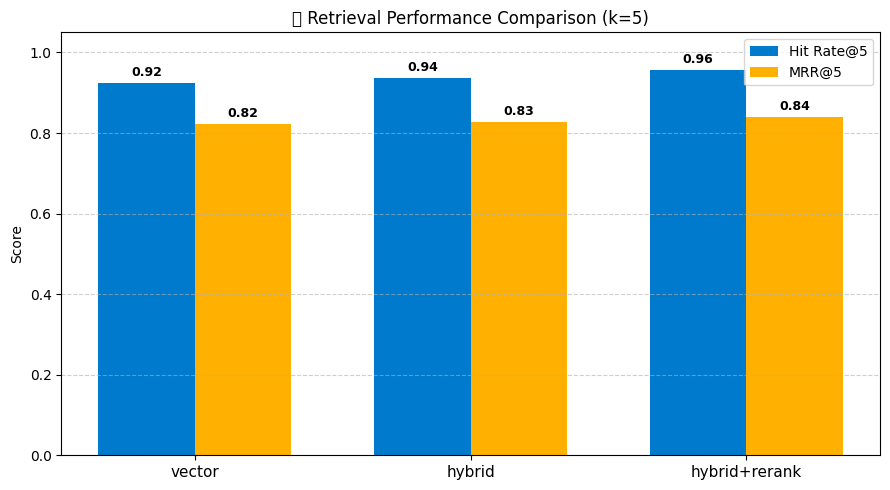

In [26]:
plot_metrics(summary)